In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize

# https://www.kaggle.com/datasets/sbhatti/news-summarization
data = pd.read_csv('news-summarization/data.csv', nrows=20000)
data = data[data['Summary'].str.len() < 2000]
data = data[data['Content'].str.len() < 5000]

data = data[data['Summary'].str.len() > 2]
data = data[data['Content'].str.len() > 5]

In [2]:
data.iloc[:, 2:]

,Content,Summary,Dataset
0,New York police are concerned drones could bec...,Police have investigated criminals who have ri...,CNN/Daily Mail
1,By . Ryan Lipman . Perhaps Australian porn sta...,Porn star Angela White secretly filmed sex act...,CNN/Daily Mail
3,An Ebola outbreak that began in Guinea four mo...,World Health Organisation: 635 infections and ...,CNN/Daily Mail
4,By . Associated Press and Daily Mail Reporter ...,A sinkhole opened up at 5:15am this morning in...,CNN/Daily Mail
5,Jerusalem woke up on Tuesday to horrific image...,Two Palestinians carried out a deadly attack o...,CNN/Daily Mail
...,...,...,...
19994,By . Daily Mail Reporter . PUBLISHED: . 11:40 ...,South Korean man jumping off building kills gi...,CNN/Daily Mail
19995,"By . Chris Greenwood . PUBLISHED: . 07:53 EST,...","Neil Iron, 32, allegedly spiked desserts to 'l...",CNN/Daily Mail
19996,Politicians debated the piece of legislation i...,MLAs at Stormont have voted the Welfare Reform...,XSum
19998,"(CNN Student News) -- August 11, 2014 . CNN St...",This page includes the show Transcript .\nUse ...,CNN/Daily Mail


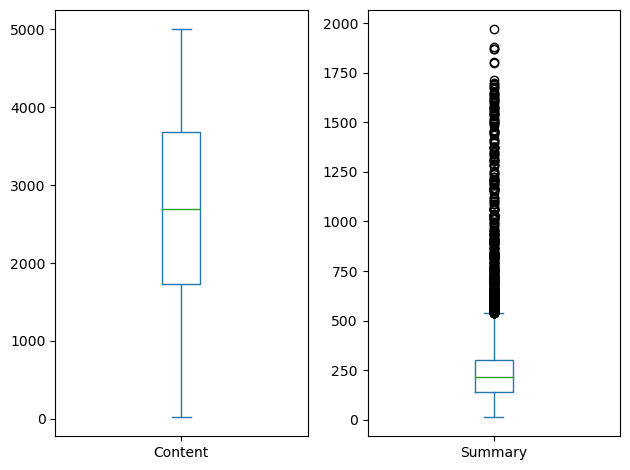

In [3]:
plt.subplot(121)
data['Content'].str.len().plot(kind='box')

plt.subplot(122)
data['Summary'].str.len().plot(kind='box')
plt.tight_layout()

In [4]:
sent_tokenize(data['Content'].iloc[0].replace('\n', '. ').replace('..', '.'))

['New York police are concerned drones could become tools for terrorists, and are investigating ways to stop potential attacks.',
 "Until now police haven't acknowledged drones as a potential weapon, but the NYPD has now said the technology has advanced enough that someone could use them to carry out an air assault using chemical weapons and firearms.",
 'Police want to develop technology which will allow them to take control of drones as well as scan the skies for them before major events.',
 'The NYPD says drones carrying explosives are the number one threat as they investigate ways to stop attacks .',
 "Deputy Chief Salvatore DiPace, left, was concerned about an incident last year where a drone was landed in front of German Chancellor Angela Merkel and 'could have took the chancellor and her people out' A drone which was flown over a packed football stadium in Manchester, England, just over a week ago, resulting in the suspected pilot being arrested .",
 'They are consulting with th

In [5]:
word_tokenize(data['Summary'].iloc[0].replace('\n', '. ').replace('..', '.'))

['Police',
 'have',
 'investigated',
 'criminals',
 'who',
 'have',
 'rigged',
 'guns',
 'to',
 'drones',
 '.',
 'And',
 'are',
 'working',
 'with',
 'the',
 'military',
 'to',
 'develop',
 'technology',
 'to',
 'stop',
 'attacks',
 '.',
 'Incidents',
 'involving',
 'drones',
 'have',
 'drastically',
 'increased',
 'in',
 'New',
 'York',
 'City',
 '.',
 'Last',
 'year',
 'a',
 'drone',
 'was',
 'landed',
 'in',
 'front',
 'of',
 'German',
 'Chancellor',
 'Angela',
 'Merkel',
 '.']

In [7]:
!pip install rouge sentence-transformers transformers --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=876b75fbdf3c83c6d6030ffb5a07682f5601aa6f9bc511adfe96519535b5e9ab
  Stored in directory: /root/.cache/pip/wheels/83/71/2b/40d17d21937fed496fb99145227eca8f20b4891240ff60c86f
Successfully built sentence-transformers
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


## TextRank

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(
    sentences= [word_tokenize(x) for x in data['Content'].iloc[:]] +\
        [word_tokenize(x) for x in data['Summary'].iloc[:]],
    vector_size=100, window=5, min_count=5, workers=2
)

In [44]:
sentences = sent_tokenize(data['Content'].iloc[0].replace('\n', '. ').replace('..', '.'))
sentences_feat = [
    np.array([model.wv[x] for x in word_tokenize(sentence.lower()) if x in model.wv]).mean(0)
    for sentence in sentences]

sentences_feat = np.array(sentences_feat)

from sklearn.metrics.pairwise import cosine_similarity
sim_mat = np.zeros([len(sentences), len(sentences)])
for i in range(len(sentences)):
    for j in range(len(sentences)):
        if i != j:
            sim_mat[i][j] = cosine_similarity(sentences_feat[i].reshape(1,100), sentences_feat[j].reshape(1,100))[0,0]
            
import networkx as nx
nx_graph = nx.from_numpy_array(sim_mat)
for i in range(len(sentences)):
    for j in range(len(sentences)):
        nx_graph[2][3]['weight'] = sim_mat[i][j]
scores = nx.pagerank(nx_graph)

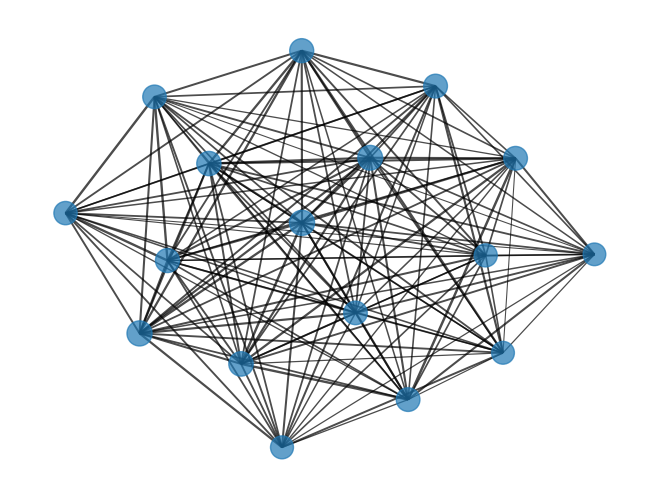

In [45]:
edges = nx_graph.edges()
weights = [nx_graph[u][v]['weight']*2 for u,v in edges]

nx.draw(nx_graph, alpha=0.7, 
        width=weights, 
        pos=nx.spring_layout(nx_graph),
        node_size=[x * 5000 for x in list(scores.values())])

In [46]:
print(sentences[np.argmax(list(scores.values()))])
print(data['Content'].iloc[0].replace('\n', '. ').replace('..', '.'))

The drone, circled, landed in front of Ms Merkel as she delivered a speech sin Germany sparking fears that the device could easily be used to commit a terrorist act .
New York police are concerned drones could become tools for terrorists, and are investigating ways to stop potential attacks. Until now police haven't acknowledged drones as a potential weapon, but the NYPD has now said the technology has advanced enough that someone could use them to carry out an air assault using chemical weapons and firearms. Police want to develop technology which will allow them to take control of drones as well as scan the skies for them before major events. The NYPD says drones carrying explosives are the number one threat as they investigate ways to stop attacks . Deputy Chief Salvatore DiPace, left, was concerned about an incident last year where a drone was landed in front of German Chancellor Angela Merkel and 'could have took the chancellor and her people out' A drone which was flown over a pa

In [47]:
from rouge import Rouge 
rouge = Rouge()
rouge.get_scores(sentences[np.argmax(list(scores.values()))], 
                          data['Summary'].iloc[0])

[{'rouge-1': {'r': 0.20512820512820512,
   'p': 0.27586206896551724,
   'f': 0.2352941127551904},
  'rouge-2': {'r': 0.06818181818181818,
   'p': 0.10344827586206896,
   'f': 0.08219177603302712},
  'rouge-l': {'r': 0.1794871794871795,
   'p': 0.2413793103448276,
   'f': 0.20588234804930808}}]

## KeyBERT

In [8]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

In [42]:
sentences = sent_tokenize(data['Content'].iloc[10].replace('\n', '. ').replace('..', '.'))
sentences_embeddings = model.encode(sentences)
doc_embeddings = model.encode(data['Content'].iloc[10])

from sklearn.preprocessing import normalize

sentences_embeddings = normalize(sentences_embeddings)
doc_embeddings = normalize(doc_embeddings.reshape(1, -1))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 0, 'BERT Similarity')

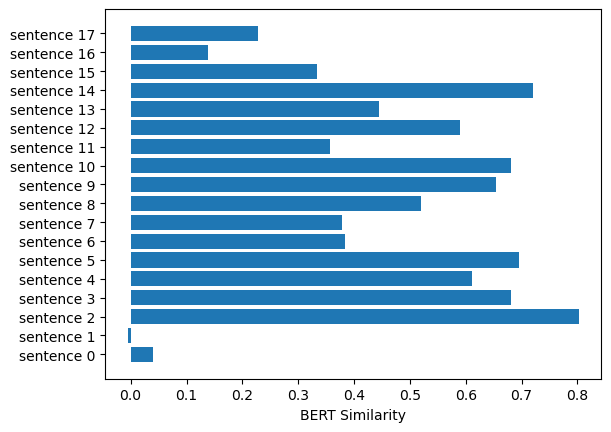

In [43]:
plt.barh(range(len(sentences)), doc_embeddings.dot(sentences_embeddings.T).reshape(-1))
_ = plt.yticks(range(len(sentences)), ['sentence ' + str(x) for x in range(len(sentences))])
plt.xlabel('BERT Similarity')

In [44]:
from rouge import Rouge 
rouge = Rouge()
rouge.get_scores(sentences[np.argmax(doc_embeddings.dot(sentences_embeddings.T))], 
                          data['Summary'].iloc[10])

[{'rouge-1': {'r': 0.37209302325581395,
   'p': 0.8421052631578947,
   'f': 0.5161290280072841},
  'rouge-2': {'r': 0.2653061224489796, 'p': 0.65, 'f': 0.3768115900861164},
  'rouge-l': {'r': 0.3488372093023256,
   'p': 0.7894736842105263,
   'f': 0.4838709634911552}}]

## T5

In [12]:
data["text"] = "summarize: " + data["Content"]

In [13]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import os

# Importing the T5 modules from huggingface/transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

class YourDataSetClass(Dataset):
  """
  Creating a custom dataset for reading the dataset and 
  loading it into the dataloader to pass it to the neural network for finetuning the model

  """

  def __init__(self, dataframe, tokenizer, source_len, target_len, source_text, target_text):
    self.tokenizer = tokenizer
    self.data = dataframe
    self.source_len = source_len
    self.summ_len = target_len
    self.target_text = self.data[target_text].values
    self.source_text = self.data[source_text].values

  def __len__(self):
    return len(self.target_text)

  def __getitem__(self, index):
    source_text = str(self.source_text[index])
    target_text = str(self.target_text[index])

    #cleaning data so as to ensure data is in string type
    source_text = ' '.join(source_text.split())
    target_text = ' '.join(target_text.split())

    source = self.tokenizer.batch_encode_plus([source_text], max_length= self.source_len, pad_to_max_length=True, truncation=True, padding="max_length", return_tensors='pt')
    target = self.tokenizer.batch_encode_plus([target_text], max_length= self.summ_len, pad_to_max_length=True, truncation=True, padding="max_length", return_tensors='pt')

    source_ids = source['input_ids'].squeeze()
    source_mask = source['attention_mask'].squeeze()
    target_ids = target['input_ids'].squeeze()
    target_mask = target['attention_mask'].squeeze()

    return {
        'source_ids': source_ids.to(dtype=torch.long), 
        'source_mask': source_mask.to(dtype=torch.long), 
        'target_ids': target_ids.to(dtype=torch.long),
        'target_ids_y': target_ids.to(dtype=torch.long)
    }

In [14]:
def train(epoch, tokenizer, model, device, loader, optimizer):
    model.train()
    for _,data in enumerate(loader, 0):
        y = data['target_ids'].to(device, dtype = torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data['source_ids'].to(device, dtype = torch.long)
        mask = data['source_mask'].to(device, dtype = torch.long)

        outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=lm_labels)
        loss = outputs[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [15]:
def validate(epoch, tokenizer, model, device, loader):
  model.eval()
  predictions = []
  actuals = []
  with torch.no_grad():
      for _, data in enumerate(loader, 0):
          y = data['target_ids'].to(device, dtype = torch.long)
          ids = data['source_ids'].to(device, dtype = torch.long)
          mask = data['source_mask'].to(device, dtype = torch.long)

          generated_ids = model.generate(
              input_ids = ids,
              attention_mask = mask, 
              max_length=150, 
              num_beams=2,
              repetition_penalty=2.5, 
              length_penalty=1.0, 
              early_stopping=True
              )
          preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
          target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
          predictions.extend(preds)
          actuals.extend(target)
  return predictions, actuals
     

In [21]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [22]:
def T5Trainer(dataframe, source_text, target_text, model_params, output_dir="./outputs/" ):
  
  """
  T5 trainer

  """

  # Set random seeds and deterministic pytorch for reproducibility
  torch.manual_seed(model_params["SEED"]) # pytorch random seed
  np.random.seed(model_params["SEED"]) # numpy random seed
  torch.backends.cudnn.deterministic = True


  # tokenzier for encoding the text
  tokenizer = T5Tokenizer.from_pretrained(model_params["MODEL"])

  # Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary. 
  # Further this model is sent to device (GPU/TPU) for using the hardware.
  model = T5ForConditionalGeneration.from_pretrained(model_params["MODEL"])
  model = model.to(device)
    
  # Importing the raw dataset
  dataframe = dataframe[[source_text,target_text]]
  
  # Creation of Dataset and Dataloader
  # Defining the train size. So 80% of the data will be used for training and the rest for validation. 
  train_size = 0.8
  train_dataset=dataframe.iloc[:int(len(dataframe) * train_size)]
  val_dataset=dataframe.iloc[int(len(dataframe) * train_size):]

  # Creating the Training and Validation dataset for further creation of Dataloader
  training_set = YourDataSetClass(train_dataset, tokenizer, model_params["MAX_SOURCE_TEXT_LENGTH"], model_params["MAX_TARGET_TEXT_LENGTH"], source_text, target_text)
  val_set = YourDataSetClass(val_dataset, tokenizer, model_params["MAX_SOURCE_TEXT_LENGTH"], model_params["MAX_TARGET_TEXT_LENGTH"], source_text, target_text)


  # Defining the parameters for creation of dataloaders
  train_params = {
      'batch_size': model_params["TRAIN_BATCH_SIZE"],
      'shuffle': True,
      'num_workers': 0
      }


  val_params = {
      'batch_size': model_params["VALID_BATCH_SIZE"],
      'shuffle': False,
      'num_workers': 0
      }

  # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
  training_loader = DataLoader(training_set, **train_params)
  val_loader = DataLoader(val_set, **val_params)


  # Defining the optimizer that will be used to tune the weights of the network in the training session. 
  optimizer = torch.optim.Adam(params =  model.parameters(), lr=model_params["LEARNING_RATE"])
  
  for epoch in range(model_params["TRAIN_EPOCHS"]):
      train(epoch, tokenizer, model, device, training_loader, optimizer)
      
  #Saving the model after training
  path = os.path.join(output_dir, "model_files")
  model.save_pretrained(path)
  tokenizer.save_pretrained(path)

  for epoch in range(model_params["VAL_EPOCHS"]):
    predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
    final_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals})
    final_df.to_csv(os.path.join(output_dir,'predictions.csv'))

In [23]:
model_params={
    "MODEL":"t5-base",             # model_type: t5-base/t5-large
    "TRAIN_BATCH_SIZE":8,          # training batch size
    "VALID_BATCH_SIZE":8,          # validation batch size
    "TRAIN_EPOCHS":3,              # number of training epochs
    "VAL_EPOCHS":1,                # number of validation epochs
    "LEARNING_RATE":1e-4,          # learning rate
    "MAX_SOURCE_TEXT_LENGTH":512,  # max length of source text
    "MAX_TARGET_TEXT_LENGTH":50,   # max length of target text
    "SEED": 42                     # set seed for reproducibility 

}

T5Trainer(dataframe=data[:500], 
          source_text="text", 
          target_text="Summary", 
          model_params=model_params, 
          output_dir="outputs")


/opt/conda/lib/python3.7/site-packages/transformers/models/t5/tokenization_t5.py:173: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [27]:
predictions = pd.read_csv('./outputs/predictions.csv')

In [30]:
from rouge import Rouge 
rouge = Rouge()
rouge.get_scores(predictions['Generated Text'].iloc[10], 
                          predictions['Actual Text'].iloc[10])

[{'rouge-1': {'r': 0.4642857142857143,
   'p': 0.3333333333333333,
   'f': 0.3880596966273112},
  'rouge-2': {'r': 0.27586206896551724, 'p': 0.2, 'f': 0.23188405309808874},
  'rouge-l': {'r': 0.42857142857142855,
   'p': 0.3076923076923077,
   'f': 0.3582089503586545}}]